# Resumo

Nesse notebook:
* Dados do dataset MNIST são manipulados.
* Uma Rede Neural Convolucional é treinada, sem CV ou Grid Search, para classificar as imagens desse dataset.

# Importando os recursos

In [31]:
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib 
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import utils
import matplotlib.pyplot as plt

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# Visualizando os dados

In [3]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [4]:
X_train, X_train.max()

(array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        ...,
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],

Ou seja, a base de treinamento tem 60000 imagens.<br>
Cada imagem é uma matriz de 28x28, onde cada valor representa um pixel.<br>
Cada pixel é representado por um valor entre 0 e 255, para indicar um ponto na escala de cinza.

In [6]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

O conjunto de treinamento y possui as classes de cada imagem.<br>
A primeira representa o dígito 5, a segunda representa o 0, e assim por diante.

Text(0.5, 1.0, 'Classe: 5')

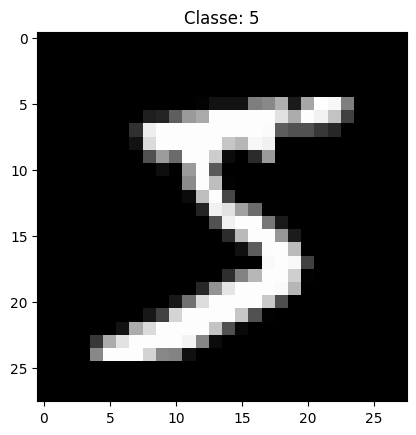

In [8]:
plt.imshow(X_train[0], cmap='gray') # plota a matriz na primeira posição de X_train em grayscale
plt.title(f'Classe: {str(y_train[0])}')

In [9]:
X_train.shape

(60000, 28, 28)

In [10]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)

In [12]:
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

Adiciona o 1 para indicar 1 canal de cor, se as imagens fossem RGB, o 3 é que seria assinalado à essa nova dimensão.<br>
O Tensorflow exige essa informação a respeito da quantidade de canais de cores.

In [13]:
X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

# Pré-processamento dos conjuntos previsores

In [15]:
X_train = X_train.astype('float32') # converte para float, para fazer a posterior normalização
X_test = X_test.astype('float32')

In [16]:
X_train /= 255 # divisão pelo valor máximo normaliza os dados entre 0 e 1
X_test /= 255

Essa normalização torna as multiplicações da convolução e da Backpropagation mais fáceis, já que os números são muito menores.

In [17]:
X_train.min(), X_train.max()  

(0.0, 1.0)

# Pré-processamento dos conjuntos de classe

Como esse é um processamento de múltiplas classes, é necessário o uso da codificação One Hot (binária) para as N classes poderem ser representadas por uma camada de saída com N neurônios.

In [18]:
y_train = utils.to_categorical(y_train, 10) # aplica One Hot Encoding para 10 classe
y_test = utils.to_categorical(y_test, 10)

In [19]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [20]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

Na posição 0, temos uma imagem do dígito 5. Por isso, tem-se um 1 na posição 5 e 0 nas outras.

# Criando a estrutura da Rede Neural Convolucional

In [32]:
network = Sequential()
network.add(InputLayer(shape = (28, 28, 1))) # 28 linhas, 28 colunas e 1 canal de cor

#1° bloco Conv-BatchNorm-MaxPool:
network.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu')) # geralmente se usa potências de 2 para o número de filtros
network.add(BatchNormalization()) # objeto que normaliza os dados da camada anterior, tornando cálculos futuros menos custosos
network.add(MaxPooling2D(pool_size = (2, 2))) # pega o maior valores em cada região 2x2 do feature map

#2° bloco Conv-BatchNorm-MaxPool:
network.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu')) # geralmente se usa potências de 2 para o número de filtros
network.add(BatchNormalization()) # objeto que normaliza os dados da camada anterior, tornando cálculos futuros menos custosos
network.add(MaxPooling2D(pool_size = (2, 2))) # pega o maior valores em cada região 2x2 do feature map

#Flattening do input:
network.add(Flatten()) # camada de Flattening

#Rede Neural Densa:
network.add(Dense(units = 128, activation = 'relu')) # geralmente se utiliza potências de 2, as thumb rules aplicadas a outros tipos de Redes Neurais não se aplicam para RNCs
network.add(Dropout(rate=0.2))
network.add(Dense(units = 128, activation = 'relu')) # geralmente se utiliza potências de 2, as thumb rules aplicadas a outros tipos de Redes Neurais não se aplicam para RNCs
network.add(Dropout(rate=0.2))
network.add(Dense(units = 10, activation = 'softmax')) # camada de saída para 10 classes. Como é multiclasse, softmax é usada

In [33]:
network.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 11, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 11, 11, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │       102,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,154 (508.41 KB)

 Trainable params: 130,026 (507.91 KB)

 Non-trainable params: 128 (512.00 B)

In [34]:
network.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

# Treinando a rede

In [35]:
network.fit(X_train, y_train, batch_size = 128, epochs = 5, 
            validation_data = (X_test, y_test))

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 35s 69ms/step - accuracy: 0.8563 - loss: 0.4659 - val_accuracy: 0.9613 - val_loss: 0.1355
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 33s 70ms/step - accuracy: 0.9803 - loss: 0.0655 - val_accuracy: 0.9818 - val_loss: 0.0536
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 32s 68ms/step - accuracy: 0.9857 - loss: 0.0461 - val_accuracy: 0.9870 - val_loss: 0.0390
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 42s 70ms/step - accuracy: 0.9894 - loss: 0.0351 - val_accuracy: 0.9893 - val_loss: 0.0325
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 32s 69ms/step - accuracy: 0.9909 - loss: 0.0291 - val_accuracy: 0.9893 - val_loss: 0.0386


Resultados com 1 só bloco Conv-BatchNorm-MaxPool e sem Dropout:

In [28]:
network.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9803 - loss: 0.0594


[0.04732941836118698, 0.9847000241279602]

Resultados da rede mais complexa:

In [36]:
network.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9856 - loss: 0.0497


[0.038648586720228195, 0.989300012588501]